# Evaluation of automatic annotations
This notebook demonstrates automatic annotation model evaluation.

First, load the required libraries.

In [1]:
import json

from matplotlib import pyplot as plt
from matplotlib import mlab
import numpy as np

Next, load the validation data

In [2]:
validation_file = "data/validation.json"
    
with open(validation_file, "r") as f:
    validation = json.load(f)
    
list(validation.keys())

['all_ious',
 'polyline_hausdorff_distances',
 'length_differences',
 'true_positives',
 'false_positives',
 'false_negatives']

Plot the Scores vs. Intersection over Union Histogram. A good model will show a peak in the top-right corner and have a high mean IoU

mean IoU: 0.8003903525507208


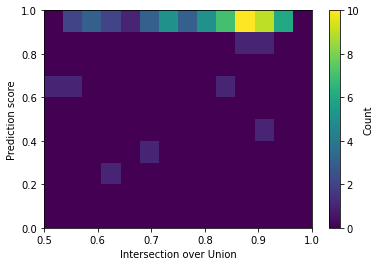

In [3]:
score_bins = np.linspace(0., 1., num=11)

ious, iou_scores = zip(*validation["all_ious"])
ious = np.array(ious)
iou_scores = np.array(iou_scores)

fig = plt.figure()

ax = fig.add_subplot(
    111,
    xlabel="Intersection over Union",
    ylabel="Prediction score",
)

iou_hist = ax.hist2d(
    ious,
    iou_scores,
    bins=(np.linspace(0.5, 1., num=15), score_bins)
)
plt.colorbar(iou_hist[-1], label="Count")

print(f"mean IoU: {np.mean(ious)}")

Plot the Scores vs. Hausdorff Distance Histogram. A good model will show a peak in the top-left corner and have a low mean Hausdorff Distance

mean hausdorff distance: 26.8674040582616


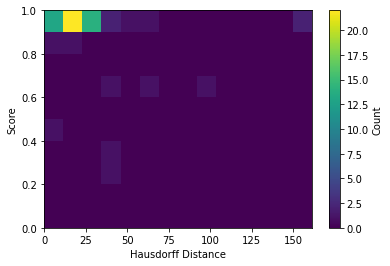

In [4]:
polyline_hausdorff_distances, phd_scores = zip(*validation["polyline_hausdorff_distances"])

polyline_hausdorff_distances = np.array(polyline_hausdorff_distances)
phd_scores = np.array(phd_scores)

fig = plt.figure()
ax = fig.add_subplot(
    111,
    xlabel="Hausdorff Distance",
    ylabel="Score",
)

phd_hist = ax.hist2d(
    polyline_hausdorff_distances,
    phd_scores,
    bins=(np.linspace(0., polyline_hausdorff_distances.max(), num=15), score_bins)
)
plt.colorbar(phd_hist[-1], label="Count")

print(f"mean hausdorff distance: {np.mean(polyline_hausdorff_distances)}")

Plot the Scores vs. Length Difference Histogram. A good model will show a peak in the top-centre, and have a low mean and standard deviation of length difference.

mean length difference: 2.3907378483120802
median length difference: -0.3598427242341131
std length difference: 40.257610580046396


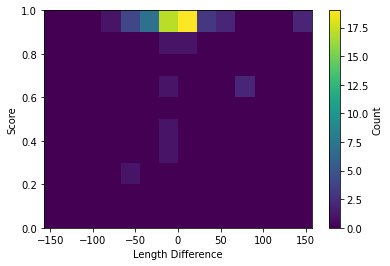

In [5]:
length_differences, l_diff_scores = zip(*validation["length_differences"])

length_differences = np.array(length_differences)
l_diff_scores = np.array(l_diff_scores)

fig = plt.figure()
ax = fig.add_subplot(
    111,
    xlabel="Length Difference",
    ylabel="Score",
)

max_diff = np.abs(length_differences).max()
l_diff_hist = ax.hist2d(
    length_differences,
    l_diff_scores,
    bins=(np.linspace(-max_diff, max_diff, num=15), score_bins)
)
plt.colorbar(l_diff_hist[-1], label="Count")

print(f"mean length difference: {np.mean(length_differences)}")
print(f"median length difference: {np.median(length_differences)}")
print(f"std length difference: {np.std(length_differences)}")

Plot the score histograms for true positives and false positives. A good model will have a peak in true positives close to 1 and lower scores for false positives.

True positives:    64
False positives:  113
False negatives:   25


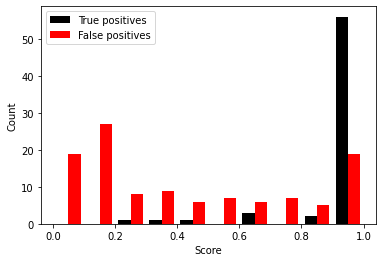

In [6]:
fig = plt.figure()
ax = fig.add_subplot(
    111,
    xlabel="Score",
    ylabel="Count",
)


h, b, p = ax.hist(
    [validation["true_positives"], validation["false_positives"]],
    bins=score_bins,
    label=["True positives", "False positives"],
    color=["k", "r"],
)
ax.legend()

print(f'True positives:  {len(validation["true_positives"]):4d}')
print(f'False positives: {len(validation["false_positives"]):4d}')
print(f'False negatives: {validation["false_negatives"]:4d}')

Plot Precision vs. Recall and calculate average precision

AP_50: 0.6823916331895055


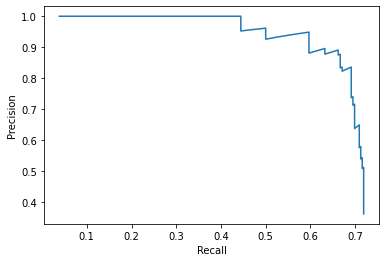

In [7]:
true_positives = np.array(validation["true_positives"])
false_positives = np.array(validation["false_positives"])
false_negatives = validation["false_negatives"]

precision = [0.]
recall = [1.]

for score_cutoff in np.sort(np.concatenate((true_positives, false_positives))):
    tp = np.count_nonzero(true_positives >= score_cutoff)
    fp = np.count_nonzero(false_positives >= score_cutoff)
    try:
        pr = tp / (tp + fp)
        re = tp / (tp + false_negatives)
    except ZeroDivisionError:
        pass
    finally:
        precision.append(pr)
        recall.append(re)
        
precision.append(1.)
recall.append(0.)
        
precision = np.array(precision)
recall = np.array(recall)
        
fig = plt.figure()
ax = fig.add_subplot(
    111,
    xlabel="Recall",
    ylabel="Precision",
)
ax.plot(recall[1:-1], precision[1:-1])

ap_precision_values = []
for ap_recall_value in np.linspace(0., 1., num=11, endpoint=True):
    ap_precision_values.append(precision[recall >= ap_recall_value].max())

average_precision = sum(ap_precision_values) / len(ap_precision_values)
print(f"AP_50: {average_precision}")

Putting together one figure

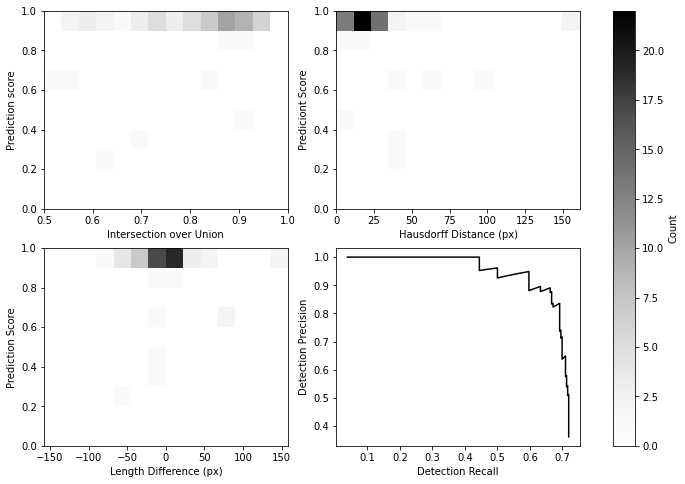

In [8]:
vmax = max(iou_hist[0].max(), phd_hist[0].max(), l_diff_hist[0].max())
cmap = "Greys"

fig = plt.figure(
    figsize=(12, 8),
)

# IoU
ax1 = fig.add_subplot(
    221,
    xlabel="Intersection over Union",
    ylabel="Prediction score",
)

iou_hist = ax1.hist2d(
    ious,
    iou_scores,
    bins=(np.linspace(0.5, 1., num=15), score_bins),
    vmax=vmax,
    cmap=cmap,
)
#plt.colorbar(iou_hist[-1], label="Count")

# H_distance
ax2 = fig.add_subplot(
    222,
    xlabel="Hausdorff Distance (px)",
    ylabel="Prediciont Score",
)

phd_hist = ax2.hist2d(
    polyline_hausdorff_distances,
    phd_scores,
    bins=(np.linspace(0., polyline_hausdorff_distances.max(), num=15), score_bins),
    vmax=vmax,
    cmap=cmap,
)
#plt.colorbar(phd_hist[-1], label="Count")

# l_diff
ax3 = fig.add_subplot(
    223,
    xlabel="Length Difference (px)",
    ylabel="Prediction Score",
)

l_diff_hist = ax3.hist2d(
    length_differences,
    l_diff_scores,
    bins=(np.linspace(-max_diff, max_diff, num=15), score_bins),
    vmax=vmax,
    cmap=cmap,
)
#plt.colorbar(l_diff_hist[-1], label="Count")

# Precision vs. Recall
ax4 = fig.add_subplot(
    224,
    xlabel="Detection Recall",
    ylabel="Detection Precision",
)
ax4.plot(
    recall[1:-1],
    precision[1:-1],
    c="k",
)


fig.colorbar(l_diff_hist[-1], ax=fig.axes, label="Count")

In [9]:
fig.savefig("autoannotation_evaluation_figure.pdf", dpi=1000.0, pad_inches=0.0, bbox_inches="tight")